시각화

In [ ]:
"""
make_rollout_gifs.py
────────────────────
GT vs No-sched      → rollout_nos.gif
GT vs SS-0.8        → rollout_ss08.gif
GT vs SS-0.9        → rollout_ss09.gif
"""

import numpy as np, matplotlib.pyplot as plt, imageio, os

# ────────── 경로 설정 ────────── #
GT_NPY   = 'gt_seq.npy'
PRED_NPYS = {
    'rollout_nos.gif'  : 'rollout_nos.npy',
    'rollout_ss08.gif' : 'rollout_ss08.npy',
    'rollout_ss09.gif' : 'rollout_ss09.npy'
}

# ────────── 시각화 파라미터 ────────── #
CMAP_FIELD = 'coolwarm'
CMAP_DIFF  = 'bwr'
FPS  = 5
DPI  = 150

# ────────── 데이터 로드 ────────── #
gt_seq = np.load(GT_NPY)                         # (97,128,128)
T, NX, NY = gt_seq.shape
print(f'GT loaded  →  {GT_NPY}   {gt_seq.shape}')

# ────────── GIF 생성 함수 ────────── #
def make_gif(pred_path, out_gif):
    pred_seq = np.load(pred_path)                # (97,128,128)
    assert pred_seq.shape == gt_seq.shape, "shape mismatch!"

    frames = []
    for i in range(T):
        gt   = gt_seq[i]
        pred = pred_seq[i]
        diff = gt - pred

        vmin, vmax = gt.min(), gt.max()          # GT 스케일 고정

        fig, ax = plt.subplots(1, 3, figsize=(9, 3), dpi=DPI,
                               gridspec_kw={'wspace': 0.30})

        # ── GT ──
        im0 = ax[0].imshow(gt, cmap=CMAP_FIELD, origin='lower',
                           vmin=vmin, vmax=vmax)
        ax[0].set_title(f"GT  t+{i+1}"); ax[0].axis('off')
        plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.02)

        # ── Pred ──
        im1 = ax[1].imshow(pred, cmap=CMAP_FIELD, origin='lower',
                           vmin=vmin, vmax=vmax)
        ax[1].set_title("Pred"); ax[1].axis('off')
        plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.02)

        # ── Diff ──
        im2 = ax[2].imshow(diff, cmap=CMAP_DIFF, origin='lower',
                           vmin=vmin, vmax=vmax)
        ax[2].set_title("GT − Pred"); ax[2].axis('off')
        plt.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.02)

        plt.tight_layout()
        fig.canvas.draw()
        frames.append(np.asarray(fig.canvas.renderer.buffer_rgba()))
        plt.close(fig)

    imageio.mimsave(out_gif, frames, fps=FPS)
    print(f'✔️  GIF saved → {out_gif}  ({T} frames)')

# ────────── 실행 ────────── #
for gif_name, pred_npy in PRED_NPYS.items():
    if not os.path.exists(pred_npy):
        print(f'!! {pred_npy} not found, skip'); continue
    make_gif(pred_npy, gif_name)


EK

In [ ]:
"""
energy_spectrum_gif.py
──────────────────────
❶ gt_seq.npy               (GT,      shape=(97,128,128))
❷ rollout_ss08.npy         (ε10=0.80, shape=(97,128,128))
❸ rollout_ss09.npy         (ε10=0.90, shape=(97,128,128))
❹ rollout_nos.npy          (no-sched, shape=(97,128,128))

   def energy_spectrum_from_vorticity(L,nx,ny,w): ...
▶ GIF 저장: spec.gif
"""

import numpy as np, matplotlib.pyplot as plt, imageio
from tqdm import tqdm

# ───────── 사용자가 준 함수 그대로 불러오기 ─────────

def energy_spectrum_from_vorticity(L, nx,ny,w):
    
    '''
    Computation of energy spectrum and maximum wavenumber from vorticity field
    
    Inputs
    ------
    nx,ny : number of grid points in x and y direction
    w : vorticity field in physical spce (including periodic boundaries)
    
    Output
    ------
    en : energy spectrum computed from vorticity field
    n : maximum wavenumber
    '''
    
    epsilon = 1.0e-6
    dx = L/nx

    kx = np.empty(nx)
    ky = np.empty(ny)
    
    kx[0:int(nx/2)] = 2*np.pi/(np.float64(nx)*dx)*np.float64(np.arange(0,int(nx/2)))
    kx[int(nx/2):nx] = 2*np.pi/(np.float64(nx)*dx)*np.float64(np.arange(-int(nx/2),0))

    ky[0:ny] = kx[0:ny]
    
    kx[0] = epsilon
    ky[0] = epsilon

    kx, ky = np.meshgrid(kx, ky, indexing='ij')
    
    a = pyfftw.empty_aligned((nx,ny),dtype= 'complex128')
    b = pyfftw.empty_aligned((nx,ny),dtype= 'complex128')

    fft_object = pyfftw.FFTW(a, b, axes = (0,1), direction = 'FFTW_FORWARD')
    wf = fft_object(w[0:nx,0:ny]) 
    
    es =  np.empty((nx,ny))
    
    kk = np.sqrt(kx[:,:]**2 + ky[:,:]**2)
    es[:,:] = np.pi*((np.abs(wf[:,:])/(nx*ny))**2)/kk
    
    n = int(np.sqrt(nx*nx + ny*ny)/2.0)-1
    
    en = np.zeros(n+1)
    
    for k in range(1,n+1):
        en[k] = 0.0
        ic = 0
        ii,jj = np.where((kk[1:,1:]>(k-0.5)) & (kk[1:,1:]<(k+0.5)))
        ic = ii.size
        ii = ii+1
        jj = jj+1
        en[k] = np.sum(es[ii,jj])
                    
        en[k] = en[k]/ic
        
    return en, n
# ───────── 설정 ─────────
L   = 6.283
NX = NY = 128
GIF_FPS = 5

files = {
    'GT'  : 'gt_seq.npy',
    'SS08': 'rollout_ss08.npy',
    'SS09': 'rollout_ss09.npy',
    'NOS' : 'rollout_nos.npy'
}
seq = {k: np.load(fn) for k, fn in files.items()}   # 모두 (T,128,128)
T   = seq['GT'].shape[0]

# ───────── 스펙트럼 계산 (당신 함수 그대로) ─────────
# ───────── 스펙트럼 계산 (0번째 버림) ─────────
spec = {k: [] for k in seq}

for t in tqdm(range(T)):
    for name in seq:
        en, nmax = energy_spectrum_from_vorticity(L, NX, NY, seq[name][t])
        spec[name].append(en[1:])      # ← k=0 항 제거!
k_axis = np.arange(1, nmax+1)          # 길이 = nmax = 89
for k in spec:
    spec[k] = np.asarray(spec[k])      # (T, 89)


# ───────── GIF 생성 ─────────
frames = []
for i in range(T):
    fig, ax = plt.subplots(figsize=(4.2,3.2))
    ax.loglog(k_axis, spec['GT'][i],  'k' , label='GT')
    ax.loglog(k_axis, spec['SS08'][i],'r--',label='SS ε10=0.80')
    ax.loglog(k_axis, spec['SS09'][i],'g-.',label='SS ε10=0.90')
    ax.loglog(k_axis, spec['NOS'][i], 'b:' ,label='No-sched')
    ax.set_xlabel('wavenumber k'); ax.set_ylabel('E(k)')
    ax.set_ylim(1e-10, 1e1); ax.set_title(f'Spectrum  frame {i}')
    ax.legend(fontsize=7); ax.grid(alpha=0.3)
    fig.tight_layout(); fig.canvas.draw()
    frames.append(np.asarray(fig.canvas.renderer.buffer_rgba()))
    plt.close(fig)

imageio.mimsave('spec.gif', frames, fps=GIF_FPS)
print('✅ spec.gif saved')


RMS(All time step Frames) (정규화x GT)

0.98997104


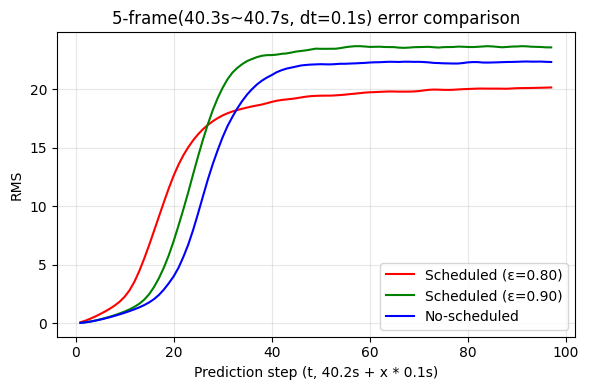

In [5]:
import numpy as np, tensorflow as tf, matplotlib.pyplot as plt

# ───── 경로 & 파라미터 ─────
# DATA_PATH   = '../v01/vorticity/vorticity50_500_128.npy'
# MODEL_SS08  = 'best_sched_model4.keras'       # ε10 = 0.80  (Scheduled-0.8)
# MODEL_SS09  = 'best_sched_ep10_09.keras'      # ε10 = 0.90  (Scheduled-0.9)
# MODEL_NOS   = 'best_nosched_model.keras'      # No-scheduled
# MODEL_26   = 'best_sched_model.keras'      # No-scheduled
INPUT_SEQ   = 3
PRED_STEPS  = 97
    
gt_seq = np.load('../gt_seq.npy')
print(np.mean((gt_seq[0])**2))
pred_ss08 = np.load('../rollout_ss08.npy')
pred_ss09 = np.load('../rollout_ss09.npy')
pred_nos  = np.load('../rollout_nos.npy')
#pred_26 = rollout(MODEL_26)

# ───── 3. RMS 계산 ─────
mse_ss08 = np.sqrt(np.mean((pred_ss08 - gt_seq)**2, axis=(1,2)))
mse_ss09 = np.sqrt(np.mean((pred_ss09 - gt_seq)**2, axis=(1,2)))
mse_nos  = np.sqrt(np.mean((pred_nos  - gt_seq)**2, axis=(1,2)))
#mse_26  = np.mean((pred_26  - gt_seq)**2, axis=(1,2))

# ───── 4. 그래프 ─────
plt.figure(figsize=(6,4))
steps = range(1, PRED_STEPS+1)
plt.plot(steps, mse_ss08[0:97], 'r', label='Scheduled (ε=0.80)')
plt.plot(steps, mse_ss09[0:97], 'g', label='Scheduled (ε=0.90)')
plt.plot(steps, mse_nos[0:97],  'b', label='No-scheduled')
#plt.plot(steps, mse_26,  'y', label='26')
plt.xlabel('Prediction step (t, 40.2s + x * 0.1s)')
plt.ylabel('RMS')
plt.title('5-frame(40.3s~40.7s, dt=0.1s) error comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


RMS(first 5 Frames)

In [6]:
import numpy as np, tensorflow as tf, matplotlib.pyplot as plt

# ───── 경로 & 파라미터 ─────
# DATA_PATH   = '../v01/vorticity/vorticity50_500_128.npy'
# MODEL_SS08  = 'best_sched_model4.keras'       # ε10 = 0.80  (Scheduled-0.8)
# MODEL_SS09  = 'best_sched_ep10_09.keras'      # ε10 = 0.90  (Scheduled-0.9)
# MODEL_NOS   = 'best_nosched_model.keras'      # No-scheduled
# MODEL_26   = 'best_sched_model.keras'      # No-scheduled
INPUT_SEQ   = 3
PRED_STEPS  = 5
    
gt_seq = np.load('../gt_seq.npy')[0:5]
pred_ss08 = np.load('../rollout_ss08.npy')
pred_ss09 = np.load('../rollout_ss09.npy')
pred_nos  = np.load('../rollout_nos.npy')
#pred_26 = rollout(MODEL_26)

# ───── 3. RMS 계산 ─────
mse_ss08 = np.sqrt(np.mean((pred_ss08 - gt_seq)**2, axis=(1,2)))
mse_ss09 = np.sqrt(np.mean((pred_ss09 - gt_seq)**2, axis=(1,2)))
mse_nos  = np.sqrt(np.mean((pred_nos  - gt_seq)**2, axis=(1,2)))
#mse_26  = np.mean((pred_26  - gt_seq)**2, axis=(1,2))

# ───── 4. 그래프 ─────
plt.figure(figsize=(6,4))
steps = range(1, PRED_STEPS+1)
plt.plot(steps, mse_ss08[0:5], 'r', label='Scheduled (ε=0.80)')
plt.plot(steps, mse_ss09[0:5], 'g', label='Scheduled (ε=0.90)')
plt.plot(steps, mse_nos[0:5],  'b', label='No-scheduled')
#plt.plot(steps, mse_26,  'y', label='26')
plt.xlabel('Prediction step (t, 40.2s + x * 0.1s)')
plt.ylabel('RMS')
plt.title('5-frame(40.3s~40.7s, dt=0.1s) error comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


ValueError: operands could not be broadcast together with shapes (97,128,128) (5,128,128) 

CC, SSIM

In [ ]:
"""
cc_ssim_first10.py
──────────────────
GT vs 3 모델(SS-0.8 / SS-0.9 / No-sched)
 → 최초 10 프레임의 CC·SSIM 표 & 곡선
필요 파일
  gt_seq.npy, rollout_ss08.npy, rollout_ss09.npy, rollout_nos.npy
"""

import numpy as np, matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# ---------- 유틸 ----------
def corr_coeff(a, b):
    a_ = a - a.mean();  b_ = b - b.mean()
    return float((a_ * b_).mean() /
                 (a_.std() * b_.std() + 1e-12))

# ---------- 데이터 로드 (shape = 97,128,128) ----------
gt   = np.load('gt_seq.npy').astype(np.float32)
ss08 = np.load('rollout_ss08.npy').astype(np.float32)
ss09 = np.load('rollout_ss09.npy').astype(np.float32)
nos  = np.load('rollout_nos.npy' ).astype(np.float32)

# ---------- 첫 10 프레임만 슬라이스 ----------
gt10, ss08_10, ss09_10, nos_10 = [a[:10] for a in (gt, ss08, ss09, nos)]

models = {
    'SS-0.8': ss08_10,
    'SS-0.9': ss09_10,
    'No-sched': nos_10
}

# ---------- 계산 ----------
cc_dict, ssim_dict = {}, {}
for name, arr in models.items():
    cc   = []
    ssim_v = []
    for t in range(10):
        g  = gt10[t]
        pr = arr[t]

        # CC
        cc.append(corr_coeff(pr, g))

        # SSIM (프레임별 data_range 사용)
        rng = g.max() - g.min()
        ssim_v.append(ssim(g, pr, data_range=rng))

    cc_dict[name]   = np.array(cc)
    ssim_dict[name] = np.array(ssim_v)

# ---------- 결과 출력 ----------
print('Frame  CC  /  SSIM  (GT vs 모델)')
for t in range(10):
    row = [f'{t:2d}']
    for name in models:
        row.append(f'{cc_dict[name][t]:6.3f}')
    for name in models:
        row.append(f'{ssim_dict[name][t]:6.3f}')
    print(' | '.join(row))

# ---------- (선택) 그래프 ----------
steps = np.arange(10)        # 0‥9
plt.figure(figsize=(6,3.5))
for name,col in zip(models,'r g b'.split()):
    plt.plot(steps, cc_dict[name], col+'-o', label=f'{name}  CC')
plt.ylabel('CC'); plt.xlabel('frame'); plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,3.5))
for name,col in zip(models,'r g b'.split()):
    plt.plot(steps, ssim_dict[name], col+'-s', label=f'{name}  SSIM')
plt.ylabel('SSIM'); plt.xlabel('frame'); plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout(); plt.show()


ect(Vorticity PDF만 사용)

In [ ]:
"""
comprehensive_metrics.py
────────────────────────
GT vs 3 models  (SS-0.8, SS-0.9, No-sched)
  • Energy-spectrum GIF          →  spec.gif
  • Vorticity-PDF GIF            →  pdf.gif
  • MSE / CC / CoverProb curves  →  curves.png
  • Vortex-core XY-trajectory    →  core_traj.png
  • Lagrangian tracer RMSE vs t  →  tracer_curve.png
사용 데이터
  gt_seq.npy, rollout_ss08.npy, rollout_ss09.npy, rollout_nos.npy
"""

import numpy as np, matplotlib.pyplot as plt, imageio, pyfftw, scipy.fft as sfft
from tqdm import tqdm
# ---------- 매개변수 ----------
L = 6.283
NX = NY = 128
BINS = np.linspace(-5,5,201)
DT   = 0.1            # [s]  프레임 간격
TRACER_N = 200
GIF_FPS  = 5

# ---------- 유틸 ----------
def corr_coeff(a,b):       # Pearson r
    a_=a-a.mean(); b_=b-b.mean()
    return float((a_*b_).mean()/(a_.std()*b_.std()+1e-12))

def coverage(a,b,thr=0.05):     # |err|<thr ?
    return float(np.mean(np.abs(a-b)<thr))

def velocity_from_vorticity(w): # ψ FFT → u,v (periodic)
    kx = sfft.fftfreq(NX,1./NX)*2*np.pi
    ky = sfft.fftfreq(NY,1./NY)*2*np.pi
    kx,ky = np.meshgrid(kx,ky,indexing='ij')
    k2 = kx**2+ky**2; k2[0,0]=1.
    w_hat = sfft.fft2(w)
    psi_hat = w_hat/(-k2)
    psi = sfft.ifft2(psi_hat).real
    u =  np.gradient(psi,axis=1)*(L/NY)   # ∂ψ/∂y
    v = -np.gradient(psi,axis=0)*(L/NX)   # -∂ψ/∂x
    return u,v

def q_criterion(u,v):       # 2-D Q = 0.5(ω² - S²)
    dudx = np.gradient(u,axis=1)*(L/NY)
    dudy = np.gradient(u,axis=0)*(L/NX)
    dvdx = np.gradient(v,axis=1)*(L/NY)
    dvdy = np.gradient(v,axis=0)*(L/NX)
    S2 = (dudx**2+dvdy**2)*0.5 + (dudy+dvdx)**2*0.25
    w  = dvdx - dudy
    return 0.5*(w**2 - S2)

def find_core(u,v):
    q = q_criterion(u,v)
    idx = np.unravel_index(np.argmax(q), q.shape)
    return idx              # (ix,iy)

# ---------- 데이터 로드 ----------
files = {
    'GT' : 'gt_seq.npy',
    'SS08':'rollout_ss08.npy',
    'SS09':'rollout_ss09.npy',
    'NOS':'rollout_nos.npy'
}
seq  = {k: np.load(fn) for k,fn in files.items()}
T = seq['GT'].shape[0]

# ---------- pre-alloc ----------
k_axis,_ = energy_spectrum_from_vorticity(L,NX,NY,seq['GT'][0])
spec     = {k: [] for k in seq}
pdf      = {k: [] for k in seq}
mse,cc,cov = {},{},{}
for k in seq: mse[k]=[]; cc[k]=[]; cov[k]=[]

core_traj = {k: [] for k in seq}   # (ix,iy)
# ---------- tracer 초기 위치 ----------
rng = np.random.default_rng(0)
tracer0 = rng.uniform(0,NX,(TRACER_N,2))
tracer_err = {k: [] for k in seq if k!='GT'}   # RMSE

# ---------- 메인 루프 ----------
for t in tqdm(range(T),desc='frames'):
    g = seq['GT'][t]
    # energy / pdf
    spec['GT'].append(energy_spectrum_from_vorticity(L,NX,NY,g)[0])
    pdf ['GT'].append( np.histogram(g.flatten(),BINS,density=True)[0] )
    # core & tracer on GT
    ug,vg = velocity_from_vorticity(g)
    if t==0:
        tracer_gt = tracer0.copy()
    else:   # simple euler (Δt)
        tx,ty = tracer_gt[:,0], tracer_gt[:,1]
        ui = ug[tx.astype(int)%NX , ty.astype(int)%NY]
        vi = vg[tx.astype(int)%NX , ty.astype(int)%NY]
        tracer_gt[:,0]+=ui*DT*NX/L ; tracer_gt[:,1]+=vi*DT*NY/L
    core_traj['GT'].append(find_core(ug,vg))

    # 각 모델
    for k in seq:
        if k=='GT': continue
        w = seq[k][t]
        spec[k].append(energy_spectrum_from_vorticity(L,NX,NY,w)[0])
        pdf [k].append(np.histogram(w.flatten(),BINS,density=True)[0])
        mse[k].append( np.mean((w-g)**2) )
        cc [k].append( corr_coeff(w,g) )
        cov[k].append( coverage(w,g,thr=0.05) )

        u,v = velocity_from_vorticity(w)
        core_traj[k].append(find_core(u,v))

        # tracer error
        if t==0:
            tracer = tracer0.copy()
        tx,ty = tracer[:,0], tracer[:,1]
        ui = u[tx.astype(int)%NX , ty.astype(int)%NY]
        vi = v[tx.astype(int)%NX , ty.astype(int)%NY]
        tracer[:,0]+=ui*DT*NX/L ; tracer[:,1]+=vi*DT*NY/L
        tracer_err[k].append( np.sqrt( ((tracer-tracer_gt)**2).sum(axis=1).mean() ) )

# numpy-화
for d in (spec,pdf,mse,cc,cov,core_traj,tracer_err):
    for k in d: d[k]=np.asarray(d[k])

# ---------- GIF : Vorticity PDF ----------
frames=[]
centers=0.5*(BINS[:-1]+BINS[1:])
for i in range(T):
    fig,ax=plt.subplots(1,1,figsize=(4,3))
    for k,col in zip(('GT','SS08','SS09','NOS'),'k r g b'.split()):
        ax.plot(centers,pdf[k][i],col,label=k)
    ax.set_xlim(-5,5); ax.set_ylim(bottom=0)
    ax.set_title(f'PDF frame {i}')
    ax.legend(fontsize=7); ax.grid(alpha=0.3)
    fig.tight_layout(); fig.canvas.draw()
    frames.append(np.asarray(fig.canvas.renderer.buffer_rgba()))
    plt.close(fig)
imageio.mimsave('pdf.gif',frames,fps=GIF_FPS)
print('✔️ pdf.gif saved')

# ---------- 곡선 그림 ----------
steps=np.arange(T)*DT
plt.figure(figsize=(6,4))
for k,c in zip(('SS08','SS09','NOS'),'r g b'.split()):
    plt.plot(steps,mse[k],'--',label=f'{k} MSE',color=c)
plt.yscale('log'); plt.xlabel('t [s]'); plt.ylabel('frame-avg MSE'); plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout(); plt.savefig('curves_mse.png'); plt.close()

plt.figure(figsize=(6,4))
for k,c in zip(('SS08','SS09','NOS'),'r g b'.split()):
    plt.plot(steps,cc[k],c,label=f'{k} CC')
plt.xlabel('t [s]'); plt.ylabel('Corr coeff'); plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout(); plt.savefig('curves_cc.png'); plt.close()

plt.figure(figsize=(6,4))
for k,c in zip(('SS08','SS09','NOS'),'r g b'.split()):
    plt.plot(steps,cov[k],c,label=f'{k} Cover p(|err|<0.05)')
plt.xlabel('t [s]'); plt.ylabel('Coverage'); plt.legend(); plt.grid(alpha=0.3)
plt.tight_layout(); plt.savefig('curves_cover.png'); plt.close()
print('✔️ curves saved (*.png)')

# # ---------- vortex core trajectory ----------
# plt.figure(figsize=(4,4))
# for k,c in zip(core_traj.keys(),'k r g b'.split()):
#     traj = np.stack(core_traj[k])
#     plt.plot(traj[:,1],traj[:,0],c,label=k)     # iy vs ix
# plt.gca().invert_yaxis(); plt.legend(fontsize=7)
# plt.title('Core trajectory (pixel)'); plt.tight_layout()
# plt.savefig('core_traj.png'); plt.close()
# print('✔️ core_traj.png saved')

# # ---------- tracer RMSE ----------
# plt.figure(figsize=(6,4))
# for k,c in zip(tracer_err.keys(),'r g b'.split()):
#     plt.plot(steps,tracer_err[k],c,label=f'{k} tracer RMSE')
# plt.xlabel('t [s]'); plt.ylabel('RMSE (pixel)'); plt.legend(); plt.grid(alpha=0.3)
# plt.tight_layout(); plt.savefig('tracer_curve.png'); plt.close()
# print('✔️ tracer_curve.png saved')
